In [52]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from scipy.stats import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft
import torch
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1)  # Increased filters
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Increased filters
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Increased filters
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)  # Added extra convolutional layer
        self.fc1 = nn.Linear(768, 128)  # Adjusted based on the output size of the last conv layer
        self.fc2 = nn.Linear(128, latent_dim)  # Additional dense layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # print("Shape before flattening:", x.shape)
        x = torch.flatten(x, start_dim=1)
        # print("Shape after flattening:", x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.conv2d_t1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_t2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_t3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2d_t4 = nn.ConvTranspose2d(64, output_channels, kernel_size=(1,1), stride=2, padding=(15,25), output_padding=(0,1))

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(-1, 256, 4, 4)
        z = F.relu(self.conv2d_t1(z))
        z = F.relu(self.conv2d_t2(z))
        z = F.relu(self.conv2d_t3(z))
        reconstruction = torch.sigmoid(self.conv2d_t4(z))
        return reconstruction

# class VAE(nn.Module):
#     def __init__(self, input_channels, latent_dim, output_channels):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(input_channels, latent_dim)
#         self.decoder = Decoder(latent_dim, output_channels)

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std

#     def forward(self, x):
#         mean, log_var = self.encoder(x)
#         z = self.reparameterize(mean, log_var)
#         return self.decoder(z), mean, log_var
    
class SupervisedVAE(nn.Module):
    def __init__(self, input_channels, latent_dim, output_channels, num_classes=13):
        super(SupervisedVAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, output_channels)
        self.classifier = nn.Linear(latent_dim, num_classes)  # Classification layer

    def forward(self, x):
        # mean, log_var = self.encoder(x)
        # z = self.reparameterize(mean, log_var)
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        class_logits = self.classifier(z)
        return reconstruction, class_logits

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

In [53]:
from scipy.stats import mode

def create_overlapping_windows_with_labels(signals, labels, window_size, overlap_size):
    step_size = window_size - overlap_size
    windowed_signals = []
    windowed_labels = []
    total_windows = 0

    for start in range(0, len(signals[0]) - window_size + 1, step_size):  # Assumes all signals are the same length
        end = start + window_size
        window = [signal[start:end] for signal in signals]
        label_window = labels[start:end]
        if len(window[0]) == window_size and len(label_window) == window_size:
            windowed_signals.append(window)
            # Using mode of labels in the window as the window label
            windowed_label = mode(label_window)[0]
            windowed_labels.append(windowed_label)
            total_windows += 1
        else:
            print(f"Skipped window from {start} to {end} due to incorrect size.")

    return np.array(windowed_signals), np.array(windowed_labels)

def create_overlapping_windows(signals, window_size, overlap_size):
    step_size = window_size - overlap_size
    windowed_signals = []
    windowed_labels = []
    total_windows = 0

    for start in range(0, len(signals[0]) - window_size + 1, step_size):  # Assumes all signals are the same length
        end = start + window_size
        window = [signal[start:end] for signal in signals]
        if len(window[0]) == window_size:
            windowed_signals.append(window)
            total_windows += 1
        else:
            print(f"Skipped window from {start} to {end} due to incorrect size.")

    return np.array(windowed_signals), np.array(windowed_labels)

def generate_multi_channel_spectrogram(windows, fs, window_type, nperseg, noverlap, nfft):
    spectrograms = []
    for window in windows:
        # Assuming window is a 2D array with shape (window_size, num_channels)
        window_spectrograms = []
        for signal in window:  # Transpose to iterate over channels
            _, _, Zxx = stft(signal, fs=fs, window=window_type, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
            spectrogram = np.log(np.abs(Zxx) + 1e-8)  # Convert to dB scale
            # # Normalize the spectrogram
            # mean = np.mean(spectrogram)
            # std = np.std(spectrogram)
            # spectrogram = (spectrogram - mean) / std
            window_spectrograms.append(spectrogram)
        # Stack to form a multi-channel spectrogram for this window
        spectrograms.append(np.stack(window_spectrograms, axis=0))
    return np.array(spectrograms)

def plot_simple_spectrogram(spectrogram, channel=0, title="Spectrogram"):
    # spectrogram should be a 3D array: [frequency, time, channel]
    plt.figure(figsize=(10, 4))
    # Display the spectrogram of a specific channel
    plt.imshow(spectrogram[:, :, channel].T, aspect='auto', origin='lower')
    plt.colorbar(label='Intensity (dB)')
    plt.title(title)
    plt.ylabel('Sample Index')
    plt.xlabel('Time Index')
    plt.show()
    
def generate_activity_grouped_spectrograms(data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft):
    activity_spectrograms = {}
    grouped_data = data.groupby('activity')
    for name, group in grouped_data:
        # print(len(group))
        windowed_signals, _ = create_overlapping_windows([group['acc_x'].values, group['acc_y'].values, group['acc_z'].values], window_size, overlap_size)
        # print(len(windowed_signals))
        spectrograms = generate_multi_channel_spectrogram(windowed_signals, fs, window_type, nperseg, noverlap, nfft)
        activity_spectrograms[name] = spectrograms
    return activity_spectrograms

class Data_Supervised(torch.utils.data.Dataset):
  def __init__(self, X, y, device='cuda'):
    self.x_data = torch.tensor(X, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    seq_in = self.x_data[idx]
    target = self.y_data[idx]
    sample = { 'spectrograms' : seq_in, 'label' : target }
    return sample

class Data_Unsupervised(torch.utils.data.Dataset):
  def __init__(self, X, device='cuda'):
    self.x_data = torch.tensor(X, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    seq_in = self.x_data[idx]
    sample = { 'spectrograms' : seq_in }
    return sample

from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score

# Loss function
def supervised_vae_loss(recon_x, x, logits, labels):
    # print(f"Recon_x size: {recon_x.size()}, x size: {x.size()}")
    MAE = F.l1_loss(recon_x, x, reduction='sum')
    # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    labels = labels.long()
    CE = F.cross_entropy(logits, labels)
    return MAE, CE, MAE + CE
def unsupervised_vae_loss(recon_x, x):
    # print(f"Recon_x size: {recon_x.size()}, x size: {x.size()}")
    MAE = F.l1_loss(recon_x, x, reduction='sum')
    # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return MAE

# Train Function
def train_unsupervised_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            data = batch['spectrograms'].to(device)
            optimizer.zero_grad()
            recon_batch, class_logits = model(data)
            MAE = unsupervised_vae_loss(recon_batch, data)
            loss = MAE
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # Learning rate scheduling
        scheduler.step()

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data = batch['spectrograms'].to(device)
                recon_batch, class_logits = model(data)
                MAE = unsupervised_vae_loss(recon_batch, data)
                loss = MAE
                total_val_loss += loss.item()

        # Logging the average losses
        avg_train_loss = total_train_loss / len(train_loader)

        avg_val_loss = total_val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses
        
def train_supervised_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_MAE = 0
        total_train_CE = 0
        all_train_predictions = []
        all_train_labels = []

        for batch in train_loader:
            data = batch['spectrograms'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            recon_batch, class_logits = model(data)
            MAE, CE, loss = supervised_vae_loss(recon_batch, data, class_logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_MAE += MAE.item()
            total_train_CE += CE.item()
            
            # Convert logits to predictions
            predictions = torch.argmax(class_logits, dim=1)
            all_train_predictions.extend(predictions.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
        # Calculate F1 Score
        train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')  # Change 'macro' to other methods if needed
        # Learning rate scheduling
        scheduler.step()

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_MAE = 0
        total_val_CE = 0
        all_val_predictions = []
        all_val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                data = batch['spectrograms'].to(device)
                labels = batch['label'].to(device)
                recon_batch, class_logits = model(data)
                MAE, CE, loss = supervised_vae_loss(recon_batch, data, class_logits, labels)
                total_val_loss += loss.item()
                total_val_MAE += MAE.item()
                total_val_CE += CE.item()
                
                val_predictions = torch.argmax(class_logits, dim=1)
                all_val_predictions.extend(val_predictions.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

  
        val_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')  # Calculate validation F1 Score

        # Logging the average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_MAE = total_train_MAE / len(train_loader)
        avg_train_CE = total_train_CE / len(train_loader)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_MAE = total_val_MAE / len(val_loader)
        avg_val_CE = total_val_CE / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_MAE:.4f}, Train CE: {avg_train_CE:.4f}, Train F1: {train_f1:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation MAE: {avg_val_MAE:.4f}, Validation CE: {avg_val_CE:.4f}, Validatiob F1: {val_f1:.4f}')
        
    return train_losses, val_losses, train_f1_scores, val_f1_scores

In [80]:
import os

MHEALTH_data_path = '../datasets/MHEALTHDATASET_CSV/'

# List all CSV files in the directory
MHEALTH_files = [f for f in os.listdir(MHEALTH_data_path) if f.endswith('.csv')]

# Create a list to hold dataframes
MHEALTH_dataframes = []

# Loop through the files and read each one into a dataframe
for file in MHEALTH_files:
    file_path = os.path.join(MHEALTH_data_path, file)
    df = pd.read_csv(file_path, skiprows=1, usecols=[0, 1, 2, 23])  # Adjust column indices as needed
    df.columns = ['acc_x', 'acc_y', 'acc_z', 'activity']
    MHEALTH_dataframes.append(df)

# Concatenate all the dataframes into one
MHEALTH_data = pd.concat(MHEALTH_dataframes, ignore_index=True)


12.0

In [82]:
# Example parameters
window_size = 200 # aroung 4sec of data
overlap_size = 100
fs = 50  # Sampling frequency is aroung 12.85

signals = [MHEALTH_data['acc_x'].values, MHEALTH_data['acc_y'].values, MHEALTH_data['acc_z'].values]
activities = MHEALTH_data['activity'].values

# Create overlapping windows for each signal and stack them to form multi-dimensional windows
windowed_signals, windowed_labels = create_overlapping_windows_with_labels(signals, activities, window_size, overlap_size)

# Generate spectrograms for each window
window_type='hann'
nperseg=32
noverlap=16
nfft=64
spectrograms = generate_multi_channel_spectrogram(windowed_signals, fs, window_type, nperseg, noverlap, nfft)

spectrograms_by_activity = generate_activity_grouped_spectrograms(MHEALTH_data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft)

# Flatten the dictionary into lists
X = []
y = []
for activity, spectrograms in spectrograms_by_activity.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        y.append(activity)  # assuming the key 'activity' is the label

X_by_activity = np.array(X)
y_by_activity = np.array(y)

# Split the data
X_train_val_by_activity, X_test_by_activity, y_train_val_by_activity, y_test_by_activity = train_test_split(X_by_activity, y_by_activity, test_size=0.01, random_state=42) # no test set
# Split the training+validation set into training and validation sets
X_train_by_activity, X_val_by_activity, y_train_by_activity, y_val_by_activity = train_test_split(X_train_val_by_activity, y_train_val_by_activity, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Split the data
X_train, X_val = train_test_split(spectrograms, test_size=0.3, random_state=42)


In [84]:
# Assuming 'spectrograms' should be a list of arrays or tensors
if isinstance(spectrograms[0], (np.ndarray, torch.Tensor)):
    print(spectrograms[0].shape)  # For numpy array or PyTorch tensor, use .shape

(3, 33, 14)


In [75]:
# Convert to PyTorch tensors and create DataLoaders
train_data = Data_Unsupervised(X_train)
val_data = Data_Unsupervised(X_val)
train_data_by_activity = Data_Supervised(X_train_by_activity, y_train_by_activity)
val_data_by_activity = Data_Supervised(X_val_by_activity, y_val_by_activity)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
train_loader_by_activity = DataLoader(train_data_by_activity, batch_size=8, shuffle=True)
val_loader_by_activity = DataLoader(val_data_by_activity, batch_size=8, shuffle=True)

In [76]:
vae2_model = SupervisedVAE(input_channels=3, latent_dim=256, output_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# supervised_vae_model.to(device)
# train_losses, val_losses = train_unsupervised_vae(vae_model, train_loader, val_loader, epochs=40, learning_rate=0.001)
# torch.save(vae_model.state_dict(), 'vae2.pth')

# # Plotting the training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Unsupervised Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Epoch 1: Train Loss: 29835.8795, Train MAE: 29834.1374, Train CE: 1.7421, Train F1: 0.1147
Validation Loss: 29145.0587, Validation MAE: 29143.9578, Validation CE: 1.1009, Validatiob F1: 0.1013
Epoch 2: Train Loss: 28689.5849, Train MAE: 28688.6020, Train CE: 0.9829, Train F1: 0.1972
Validation Loss: 28394.1150, Validation MAE: 28393.2834, Validation CE: 0.8317, Validatiob F1: 0.2480
Epoch 3: Train Loss: 28171.3069, Train MAE: 28170.3573, Train CE: 0.9495, Train F1: 0.2072
Validation Loss: 28050.4215, Validation MAE: 28049.4680, Validation CE: 0.9535, Validatiob F1: 0.2128
Epoch 4: Train Loss: 27923.9460, Train MAE: 27923.0555, Train CE: 0.8905, Train F1: 0.2425
Validation Loss: 27877.3464, Validation MAE: 27876.4775, Validation CE: 0.8688, Validatiob F1: 0.2273
Epoch 5: Train Loss: 27794.3886, Train MAE: 27793.5341, Train CE: 0.8546, Train F1: 0.2675
Validation Loss: 27781.8138, Validation MAE: 27780.9525, Validation CE: 0.8613, Validatiob F1: 0.2763
Epoch 6: Train Loss: 27721.1901, Tr

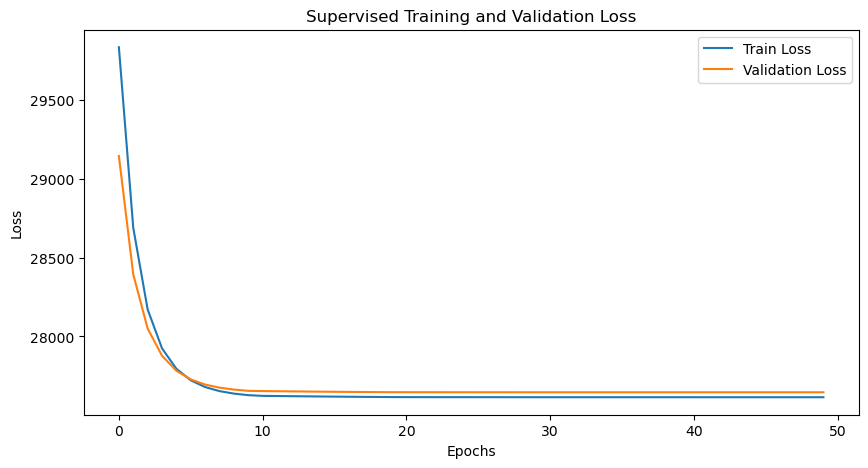

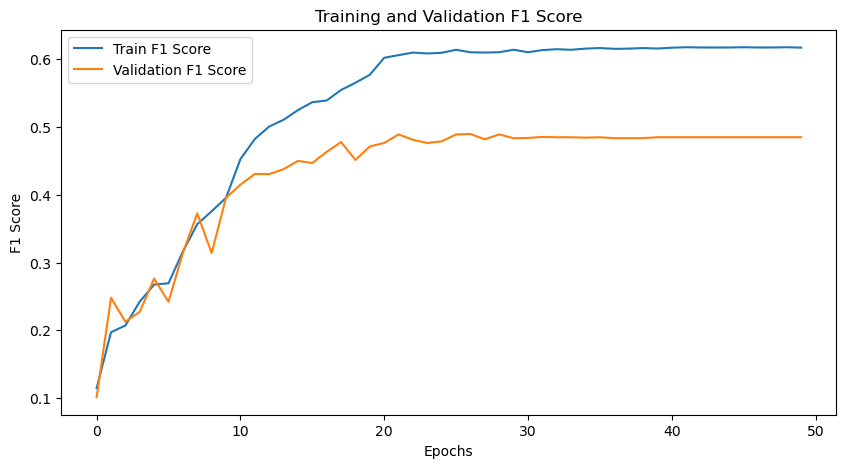

In [77]:
# vae_model.load_state_dict(torch.load('vae2.pth'))
train_losses, val_losses, train_f1_scores, val_f1_scores = train_supervised_vae(vae2_model, train_loader_by_activity, val_loader_by_activity, epochs=50, learning_rate=0.001, device=device)

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Supervised Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation F1 scores
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
